In [4]:
setwd('../../')

In [43]:
source('HiC_scripts/notebooks/libs.R')

In [5]:
loop_stats <- fread("cicero_res_v2/beta_loops_log10_anchorDist_stats.csv") %>% 
    filter(loop_set != "cicero_m05_05" | grepl("m1|m2", loop_set))

loop_stats$center_percentle = sapply(loop_stats$loop_file, getCenter)

In [9]:
loop_stats %>% filter(!grepl("_m", loop_set)) %>% select(-contains("."), -Mean, -Median)

loop_set,loop_file,nloops,nloops_filtered,celltype,center_percentle
<chr>,<chr>,<int>,<int>,<chr>,<dbl>
cicero_05_10,beta_1_beta_2.cicero_05_10.bedpe,238491,121498,beta,55.65331
cicero_10_15,beta_1_beta_2.cicero_10_15.bedpe,92484,45320,beta,56.71751
cicero_15_20,beta_1_beta_2.cicero_15_20.bedpe,38228,18068,beta,57.45793
cicero_gt_20,beta_1_beta_2.cicero_gt_20.bedpe,25174,10711,beta,57.21092
Islet_HiC,greenwald_2019_loops.bedpe,11923,5295,beta,92.94469
pcHiC,islet_pcHiC.CHiCAGO_interactions.intrachromsomal.bedpe,175122,84126,beta,81.60465


### non-perm results

### perm results

#### 0. rankAPA score

In [40]:
seed <- 1
loop_f <- paste0("./perm_np1000_nloops10000/beta_seed_", seed)
getCenter(loop_f)
calcAPA(loop_f)
getCenter(loop_f, sample = "RMM_307_1_2_3")
calcAPA(loop_f, sample = "RMM_307_1_2_3")

[1] 52.17399

[1] 0.7625261

[1] 51.48336

[1] 0.729769

In [28]:
neg_perm%>%filter(rSeed==1)

rSeed,center_percentile,sample
<int>,<dbl>,<chr>
1,51.48336,glucose_low
1,52.17399,glucose_high


In [41]:
neg_perm%>%head(1)

rSeed,center_percentile,sample
<int>,<dbl>,<chr>
2,52.03297,glucose_low


In [46]:
neg_perm_rankAPA <- do.call(rbind, lapply(1:2, function(idx) {
    cat(idx)
    do.call(rbind, mclapply(1:1000, function(seed) {
        cat(seed)
        loop_f <- paste0("./perm_np1000_nloops10000/beta_seed_", seed)
        s <- samples[idx]
        data.frame(rSeed = seed, rankAPA = calcAPA(loop_f, sample = s), sample = names(samples)[idx])
    }, mc.cores = 10))
}))
neg_perm_rankAPA %>% head(1)
neg_perm_rankAPA %>% nrow

12

rSeed,rankAPA,sample
<int>,<dbl>,<fct>
1,0.729769,glucose_low


[1] 2000

Warning message:
“Ignoring unknown parameters: bin”Warning message:
“Ignoring unknown parameters: bin”

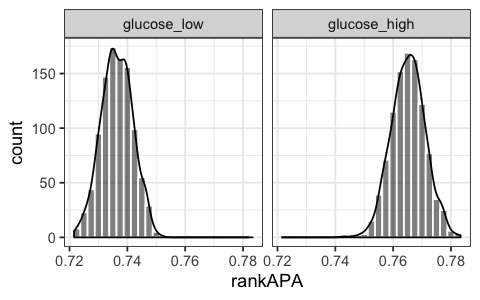

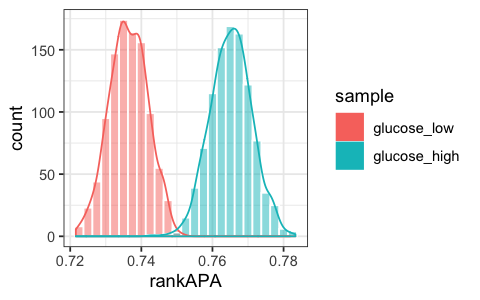

In [54]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(neg_perm_rankAPA, aes(rankAPA)) + geom_histogram(fill = "black", color = "white", 
    alpha = 0.5, binwidth = 0.0025) + geom_density(aes(y = 0.0025 * ..count..), bin = 30) + 
    theme_bw() + facet_wrap(sample ~ .)

ggplot(neg_perm_rankAPA, aes(rankAPA)) + geom_histogram(aes(fill = sample, group = sample), 
    position = "identity", color = "white", alpha = 0.5, binwidth = 0.0025) + geom_density(aes(y = 0.0025 * 
    ..count.., color = sample), bin = 30) + theme_bw()

#### 1. center percentile 

In [ ]:

neg_perm <- fread("./cicero_res_v2/beta_perm_res_RMM_307_1_2_3.txt", col.names = c("rSeed", 
    "center_percentile")) %>% mutate(sample = "glucose_low") %>% rbind(fread("./cicero_res_v2/beta_perm_res_RMM_308_1_2_3.txt", 
    col.names = c("rSeed", "center_percentile")) %>% mutate(sample = "glucose_high"))


Warning message:
“Ignoring unknown parameters: bin”Warning message:
“Ignoring unknown parameters: bin”

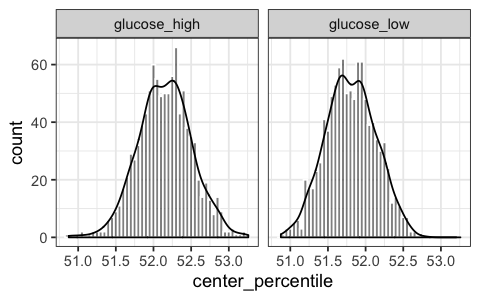

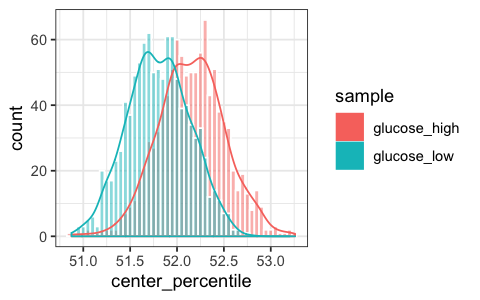

In [52]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(neg_perm, aes(center_percentile)) + geom_histogram(fill = "black", color = "white", 
    alpha = 0.5, binwidth = 0.05) + geom_density(aes(y = 0.05 * ..count..), bin = 30) + 
    theme_bw()+facet_wrap(sample~. )

ggplot(neg_perm, aes(center_percentile)) + geom_histogram(aes(fill = sample, group = sample), 
    position = "identity", color = "white", alpha = 0.5, binwidth = 0.05) + geom_density(aes(y = 0.05 * 
    ..count.., color = sample), bin = 30) + theme_bw()

In [25]:
(neg_perm_stats <- neg_perm %>% spread(sample, center_percentile) %>% select(-rSeed) %>% 
    psych::describe())

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
glucose_high,1,1000,52.15424,0.3544813,52.15122,52.15317,0.3454754,50.87483,53.25950,2.384673,-0.02911835,0.1806557,0.01120968
glucose_low,2,1000,51.80411,0.3301356,51.79706,51.80396,0.3386764,50.88788,52.77371,1.885828,0.01493911,-0.3668291,0.01043980


#### 2. combine 

In [55]:
neg_perm <- neg_perm%>%left_join(neg_perm_rankAPA)
neg_perm%>%head(1)
neg_perm%>%nrow

Joining, by = c("rSeed", "sample")
Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”

rSeed,center_percentile,sample,rankAPA
<int>,<dbl>,<chr>,<dbl>
2,52.03297,glucose_low,0.7447339


[1] 2000

In [65]:
(neg_perm_stats <- neg_perm %>% select(-rankAPA) %>% spread(sample, center_percentile) %>% 
    select(-rSeed) %>% psych::describe() %>% rownames_to_column("sample") %>% mutate(type = "center_percentile") %>% 
    rbind(neg_perm %>% select(-center_percentile) %>% spread(sample, rankAPA) %>% 
        select(-rSeed) %>% psych::describe() %>% rownames_to_column("sample") %>% 
        mutate(type = "rankAPA")))

sample,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se,type
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
glucose_high,1,1000,52.1542424,0.354481305,52.1512231,52.1531742,0.345475402,50.8748317,53.2595046,2.38467296,-0.02911835,0.18065574,0.0112096831,center_percentile
glucose_low,2,1000,51.8041081,0.330135605,51.7970627,51.8039600,0.338676448,50.8878799,52.7737075,1.88582753,0.01493911,-0.36682911,0.0104398045,center_percentile
glucose_high,1,1000,0.7652329,0.005817577,0.7653474,0.7652302,0.005834860,0.7428876,0.7833389,0.04045127,-0.03837498,0.06355906,0.0001839679,rankAPA
glucose_low,2,1000,0.7363991,0.005384030,0.7363443,0.7364091,0.005528334,0.7215805,0.7517922,0.03021166,-0.03825882,-0.31620262,0.0001702580,rankAPA


In [79]:
loop_stats <- loop_stats %>% select(loop_set, loop_file, center_percentle) %>% filter(!grepl("_m", 
    loop_set)) %>% mutate(sample = "glucose_high")
loop_stats$rankAPA <- sapply(loop_stats$loop_file, calcAPA)
tmp <- loop_stats %>% mutate(sample = "glucose_low")
tmp$rankAPA <- sapply(tmp$loop_file, calcAPA, sample = "RMM_307_1_2_3")

loop_stats <- loop_stats %>% rbind(tmp) %>% mutate(sd = 0)

In [89]:
loop_stats<- loop_stats %>% rowid_to_column("ord") %>% mutate(ord = ifelse(ord > 6, ord - 6, 
    ord)) %>% gather(type, value, c(4, 6))
loop_stats %>% head(1)
loop_stats%>%nrow

ord,loop_set,loop_file,sample,sd,type,value
<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,cicero_05_10,beta_1_beta_2.cicero_05_10.bedpe,glucose_high,0,center_percentle,55.65331


[1] 24

In [96]:
head(neg_perm,1)

rSeed,center_percentile,sample,rankAPA
<int>,<dbl>,<chr>,<dbl>
2,52.03297,glucose_low,0.7447339


In [93]:
loop_stats<- loop_stats %>% rbind(neg_perm_stats %>% mutate(ord = 0, loop_set = "neg_perm", loop_file = "neg_perm", 
    value = mean) %>% select(ord, loop_set, loop_file, sample, sd, type, value))%>%mutate(ord = ifelse(ord > 6, ord - 6, 
    ord))

loop_stats<- loop_stats %>% mutate(type = recode(type, center_percentle = "center_percentile"))


In [113]:
pvals <- sapply(1:nrow(loop_stats), function(i) {
    type <- loop_stats$type[i]
    sample <- loop_stats$sample[i]
    val <- loop_stats$value[i]
    sum(val < (neg_perm %>% filter(sample == sample))[, type])/1000
})
loop_stats$pvalue=pvals

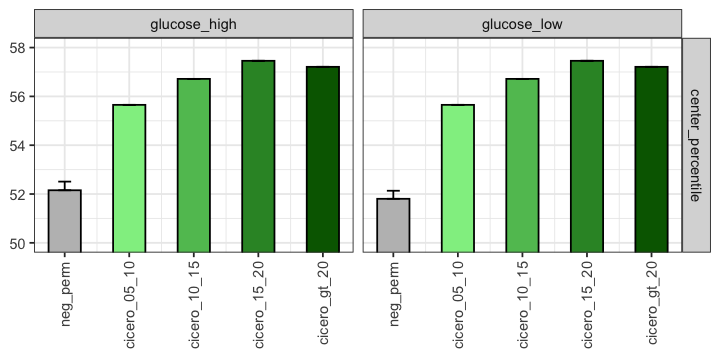

In [133]:
options(repr.plot.width = 6, repr.plot.height = 3)

p <- ggplot(loop_stats %>% filter(ord <= 4, type == "center_percentile"), aes(ord, 
    value, fill = as.factor(ord))) + geom_bar(stat = "identity", color = "black", 
    width = 0.5) + geom_errorbar(width = 0.2, aes(ymin = value, ymax = value + sd)) + 
    scale_x_continuous("Loop set", labels = loop_stats %>% filter(ord <= 4) %>% arrange(ord) %>% 
        pull(loop_set) %>% unique) + scale_fill_manual(values = c("grey", colorRampPalette(c("lightgreen", 
    "darkgreen"))(4))) + facet_grid(type ~ sample, scales = "free_y") + theme_bw() + 
    coord_cartesian(ylim = c(50, 58)) + theme(axis.title = element_blank(), legend.position = "none", 
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(p)
ggsave("~/github/islet/data/figures/HiC/subfigs/center_percentile.beta.cicero.score_bins.pdf", 
    width = 6, height = 3, units = "in", useDingbats = F)
system(paste0("open ~/github/islet/data/figures/HiC/subfigs/center_percentile.beta.cicero.score_bins.pdf"))
fwrite(p$data, "~/github/islet/data/figures/HiC/subfigs/center_percentile.beta.cicero.score_bins.csv")
system("open ~/github/islet/data/figures/HiC/subfigs/center_percentile.beta.cicero.score_bins.csv")

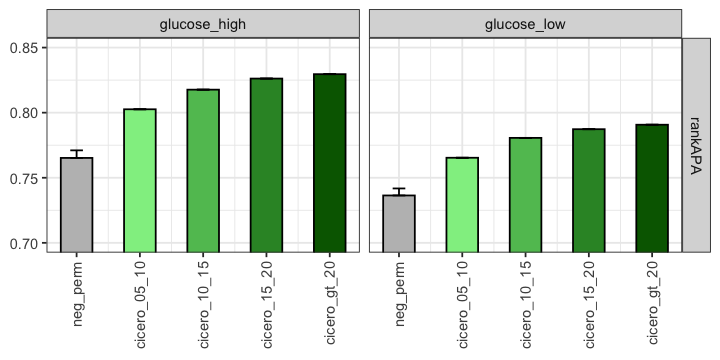

In [137]:
options(repr.plot.width = 6, repr.plot.height = 3)

p <- ggplot(loop_stats %>% filter(ord <= 4, type == "rankAPA"), aes(ord, value, fill = as.factor(ord))) + 
    geom_bar(stat = "identity", color = "black", width = 0.5) + geom_errorbar(width = 0.2, 
    aes(ymin = value, ymax = value + sd)) + scale_x_continuous("Loop set", labels = loop_stats %>% 
    filter(ord <= 4) %>% arrange(ord) %>% pull(loop_set) %>% unique) + scale_fill_manual(values = c("grey", 
    colorRampPalette(c("lightgreen", "darkgreen"))(4))) + facet_grid(type ~ sample, 
    scales = "free_y") + theme_bw() + coord_cartesian(ylim = c(.7, .85)) + theme(axis.title = element_blank(), 
    legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(p)
ggsave("~/github/islet/data/figures/HiC/subfigs/rankAPA.beta.cicero.score_bins.pdf", 
    width = 6, height = 3, units = "in", useDingbats = F)
system(paste0("open ~/github/islet/data/figures/HiC/subfigs/rankAPA.beta.cicero.score_bins.pdf"))
fwrite(p$data, "~/github/islet/data/figures/HiC/subfigs/rankAPA.beta.cicero.score_bins.csv")
system("open ~/github/islet/data/figures/HiC/subfigs/rankAPA.beta.cicero.score_bins.csv")

In [ ]:
ggplot(loop_stats, aes(ord, value, fill = as.factor(ord))) + geom_bar(stat = "identity", 
    color = "black", width = 0.5) + geom_errorbar(width = 0.2, aes(ymin = value, 
    ymax = value + sd))  + scale_fill_manual(values = c("grey", 
    colorRampPalette(c("lightgreen", "darkgreen"))(4))) + theme_bw() + theme(legend.position = "none", 
    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) + facet_grid(sample ~ 


### adding loop sets after filtering pcHiC loops

In [4]:
loop_stats <- loop_stats <- fread("./cicero_res_v2/beta_loops_log10_anchorDist_stats.csv") %>% 
    filter(loop_set != "cicero_m05_05") %>% select(loop_set, loop_file) %>% filter(!grepl("m1|m2", 
    loop_set))
loop_stats

loop_set,loop_file
cicero_05_10,beta_1_beta_2.cicero_05_10.bedpe
cicero_10_15,beta_1_beta_2.cicero_10_15.bedpe
cicero_15_20,beta_1_beta_2.cicero_15_20.bedpe
cicero_gt_20,beta_1_beta_2.cicero_gt_20.bedpe
cicero_m05_05.r100000,beta_1_beta_2.cicero_m05_05.r100000.bedpe
Islet_HiC,greenwald_2019_loops.bedpe
pcHiC,islet_pcHiC.CHiCAGO_interactions.intrachromsomal.bedpe


In [5]:
for (i in 1:4) loop_stats <- loop_stats %>% rbind(data.frame(loop_set = paste0(loop_stats$loop_set[i], 
    ".filtered_pcHiC"), loop_file = sub("bedpe", "filtered_pcHiC.bedpe", loop_stats$loop_file[i])))

loop_stats$center_percentle = sapply(1:nrow(loop_stats), function(i) {
    loop_f <- loop_stats$loop_file[i]
    (apa_file <- paste0(sample, "/apa/", loop_f, "/10000/gw/rankAPA.txt"))
    if (file.exists(apa_file)) {
        fread(cmd = paste0("cat ", apa_file, "|sed 's/\\]//g;s/\\[//g'"))[[11, 11]]
    } else {
        return(NA)
    }
    
})
loop_stats

loop_set,loop_file,center_percentle
cicero_05_10,beta_1_beta_2.cicero_05_10.bedpe,55.65331
cicero_10_15,beta_1_beta_2.cicero_10_15.bedpe,56.71751
cicero_15_20,beta_1_beta_2.cicero_15_20.bedpe,57.45793
cicero_gt_20,beta_1_beta_2.cicero_gt_20.bedpe,57.21092
cicero_m05_05.r100000,beta_1_beta_2.cicero_m05_05.r100000.bedpe,51.89385
Islet_HiC,greenwald_2019_loops.bedpe,92.94469
pcHiC,islet_pcHiC.CHiCAGO_interactions.intrachromsomal.bedpe,81.60465
cicero_05_10.filtered_pcHiC,beta_1_beta_2.cicero_05_10.filtered_pcHiC.bedpe,52.84999
cicero_10_15.filtered_pcHiC,beta_1_beta_2.cicero_10_15.filtered_pcHiC.bedpe,53.86452
cicero_15_20.filtered_pcHiC,beta_1_beta_2.cicero_15_20.filtered_pcHiC.bedpe,54.44605


type,loop_set,center_percentle,sd,p
1,cicero_05_10.filtered_pcHiC,52.84999,0.0000000,0.026
2,cicero_10_15.filtered_pcHiC,53.86452,0.0000000,0.000
3,cicero_15_20.filtered_pcHiC,54.44605,0.0000000,0.000
4,cicero_gt_20.filtered_pcHiC,54.24724,0.0000000,0.000
0,cicero_neg_perm,52.15422,0.3545125,0.498


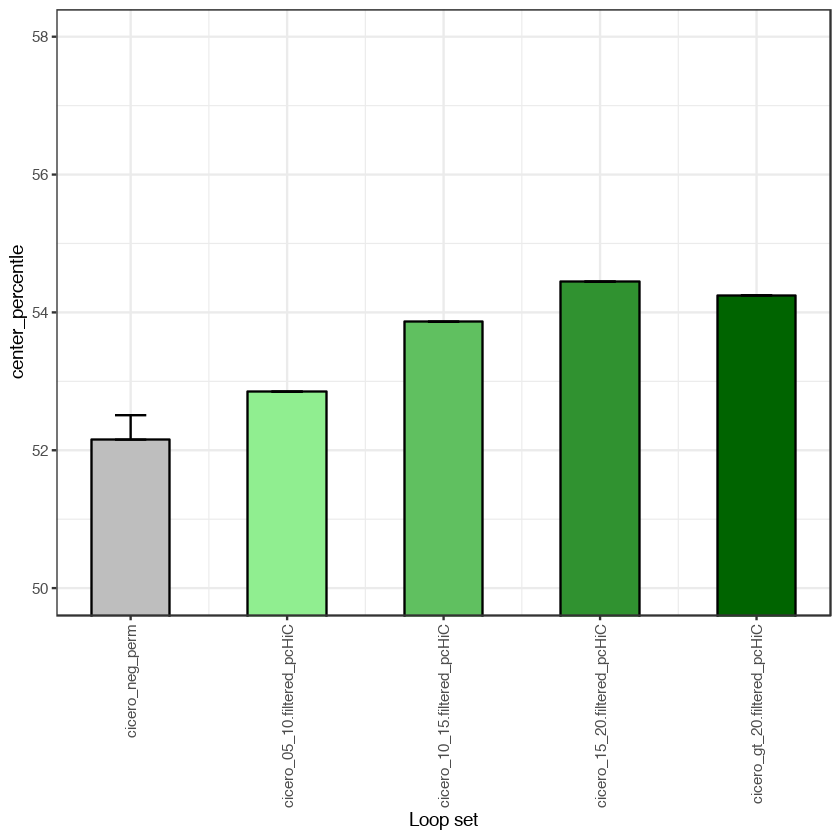

In [28]:
pd <- loop_stats %>% filter(grepl("filter", loop_set)) %>% select(loop_set, center_percentle) %>% 
    mutate(sd = 0) %>% rowid_to_column("type") %>% add_row(loop_set = "cicero_neg_perm", 
    center_percentle = neg_perm_stats$mean, sd = neg_perm_stats$sd, type = 0)
pd$p <- sapply(pd$center_percentle, function(x) sum(x < neg_perm$center_percentile)/1000)
pd

ggplot(pd, aes(type, center_percentle, fill = as.factor(type))) + geom_bar(stat = "identity", 
    color = "black", width = 0.5) + geom_errorbar(width = 0.2, aes(ymin = center_percentle, 
    ymax = center_percentle + sd)) + scale_x_continuous("Loop set", labels = pd %>% 
    arrange(type) %>% pull(loop_set)) + scale_fill_manual(values = c("grey", colorRampPalette(c("lightgreen", 
    "darkgreen"))(4))) + theme_bw() + theme(legend.position = "none", axis.text.x = element_text(angle = 90, 
    hjust = 1, vjust = 0.5)) + coord_cartesian(ylim = c(50, 58))

In [36]:
pd <- loop_stats %>% filter(!loop_set %in% c("pcHiC", "Islet_HiC") & !grepl("m", 
    loop_set)) %>% select(loop_set, center_percentle) %>% mutate(sd = 0) %>% rowid_to_column("type") %>% 
    add_row(loop_set = "cicero_neg_perm", center_percentle = neg_perm_stats$mean, 
        sd = neg_perm_stats$sd, type = 0) %>% mutate(loop_set_clean = sub(".filtered_pcHiC", 
    "", loop_set)) %>% mutate(type = ifelse(type > 4, type - 4, type), filtered = grepl("filtered", 
    loop_set))
pd$p <- sapply(pd$center_percentle, function(x) sum(x < neg_perm$center_percentile)/1000)
pd

type,loop_set,center_percentle,sd,loop_set_clean,filtered,p
1,cicero_05_10,55.65331,0.0000000,cicero_05_10,FALSE,0.000
2,cicero_10_15,56.71751,0.0000000,cicero_10_15,FALSE,0.000
3,cicero_15_20,57.45793,0.0000000,cicero_15_20,FALSE,0.000
4,cicero_gt_20,57.21092,0.0000000,cicero_gt_20,FALSE,0.000
1,cicero_05_10.filtered_pcHiC,52.84999,0.0000000,cicero_05_10,TRUE,0.026
2,cicero_10_15.filtered_pcHiC,53.86452,0.0000000,cicero_10_15,TRUE,0.000
3,cicero_15_20.filtered_pcHiC,54.44605,0.0000000,cicero_15_20,TRUE,0.000
4,cicero_gt_20.filtered_pcHiC,54.24724,0.0000000,cicero_gt_20,TRUE,0.000
0,cicero_neg_perm,52.15422,0.3545125,cicero_neg_perm,FALSE,0.498


In [46]:
pd %>% arrange(type) %>% pull(loop_set_clean) 

[1] "cicero_neg_perm" "cicero_05_10"    "cicero_05_10"    "cicero_10_15"   
[5] "cicero_10_15"    "cicero_15_20"    "cicero_15_20"    "cicero_gt_20"   
[9] "cicero_gt_20"

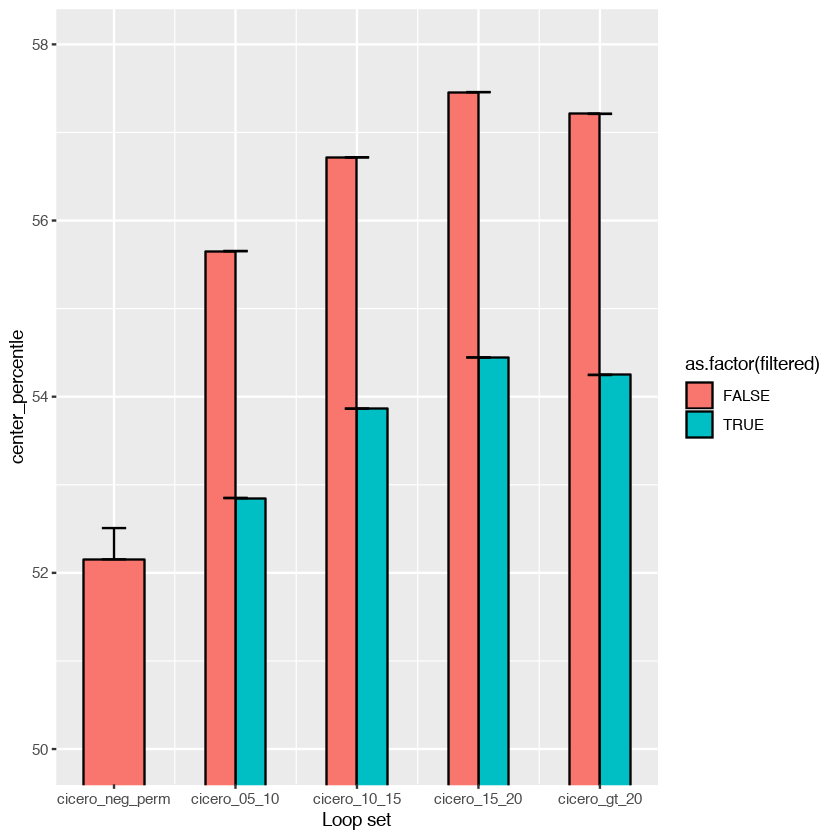

In [47]:
ggplot(pd, aes(type, center_percentle, fill = as.factor(filtered))) + geom_bar(aes(color = filtered), 
    stat = "identity", position = "dodge", color = "black", width = 0.5) + geom_errorbar(width = 0.2, 
    aes(ymin = center_percentle, ymax = center_percentle + sd)) + scale_x_continuous("Loop set", 
    labels = pd %>% arrange(type) %>% pull(loop_set_clean)%>%unique) + coord_cartesian(ylim = c(50, 
    58))